In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing


from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Loading the exchange rate dataset — locking the timeline before any tuning begins
df = pd.read_csv(
    'exchange_rate.csv',
    parse_dates=['date'],
    date_parser=lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M')
)

# Setting the date column as index — this becomes our time axis
df.set_index('date', inplace=True)
df = df.sort_index()  # just in case the rows weren’t in order

# Quick peek — confirming structure and rhythm
print(df.head())

            Ex_rate
date               
1990-01-01   0.7855
1990-01-02   0.7818
1990-01-03   0.7867
1990-01-04   0.7860
1990-01-05   0.7849


/tmp/ipython-input-136807803.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(


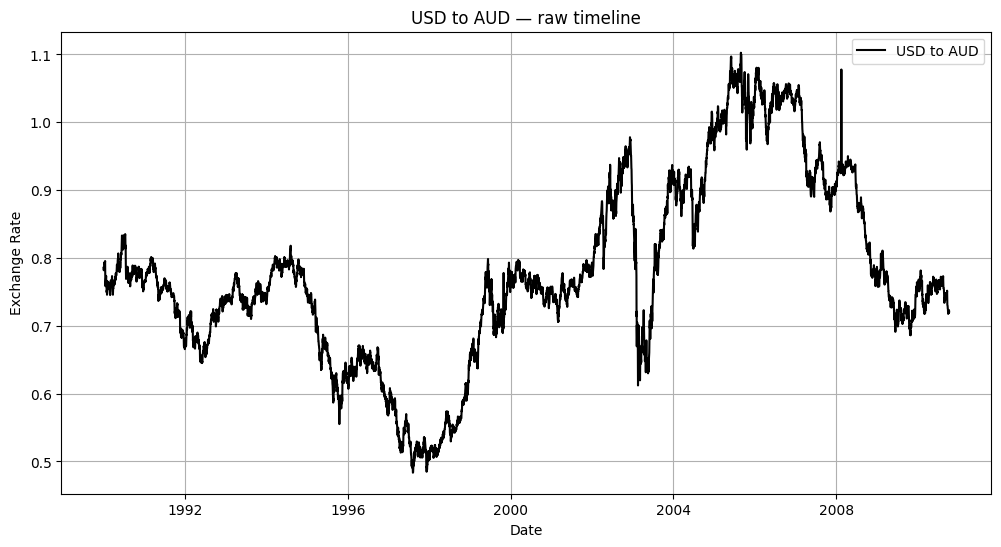

In [ ]:
# Plotting the exchange rate — no filters, just watching how it moves over time
plt.figure(figsize=(12, 6))
plt.plot(df['Ex_rate'], color='black', label='USD to AUD')

# Keeping it minimal — title, labels, grid
plt.title('USD to AUD — raw timeline')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Quick check — making sure there’s nothing broken before we tune
print("Missing values:")
print(df.isnull().sum())

# Just feeling the range — not analyzing yet
print("Basic stats:")
print(df.describe())

Missing values:
Ex_rate    0
dtype: int64
Basic stats:
           Ex_rate
count  7588.000000
mean      0.776974
std       0.136620
min       0.483297
25%       0.701422
50%       0.761377
75%       0.873477
max       1.102536


In [ ]:
# Performing Augmented Dickey-Fuller test to assess stationarity of the original exchange rate series
adf_stat, p_val, *_ = adfuller(df['Ex_rate'])
print(f"ADF Statistic (original): {adf_stat:.4f}")
print(f"p-value (original): {p_val:.4f}")

ADF Statistic (original): -1.6650
p-value (original): 0.4492


In [ ]:
# Applying first-order differencing to remove trend and stabilize the series
df['Ex_rate_diff'] = df['Ex_rate'].diff()

# Re-running ADF test on the differenced series to confirm stationarity
adf_diff_stat, p_diff_val, *_ = adfuller(df['Ex_rate_diff'].dropna())
print(f"ADF Statistic (differenced): {adf_diff_stat:.4f}")
print(f"p-value (differenced): {p_diff_val:.4f}")

ADF Statistic (differenced): -99.3934
p-value (differenced): 0.0000


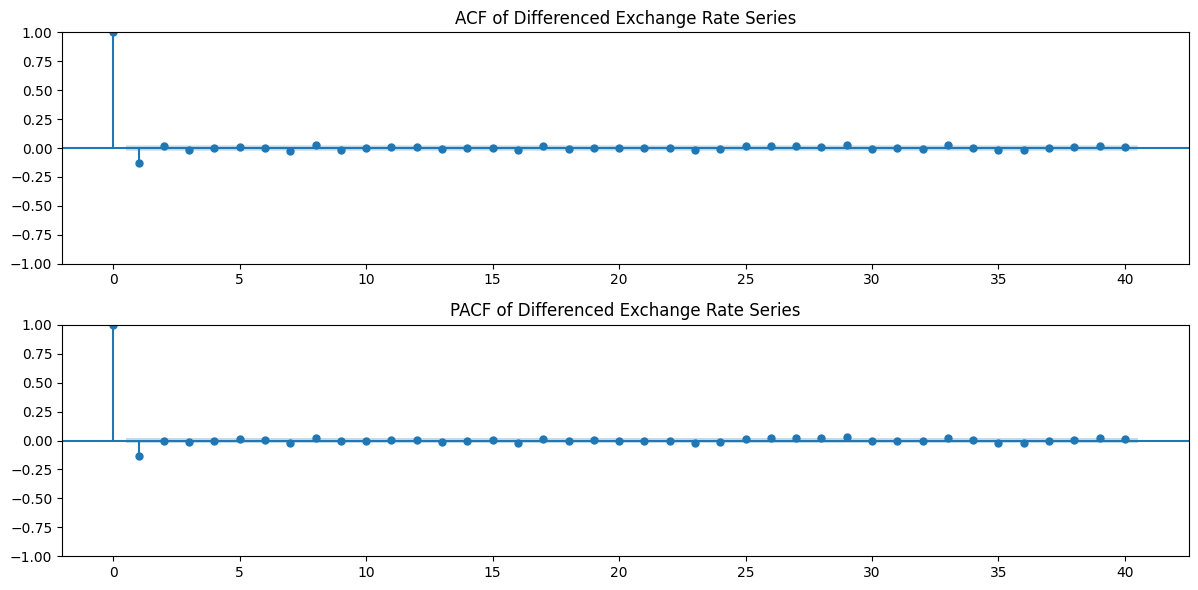

In [ ]:
# Plotting ACF and PACF of the differenced series to estimate ARIMA parameters p and q
plt.figure(figsize=(12, 6))

# Autocorrelation Function — helps estimate q (MA component)
plt.subplot(211)
plot_acf(df['Ex_rate_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF of Differenced Exchange Rate Series')

# Partial Autocorrelation Function — helps estimate p (AR component)
plt.subplot(212)
plot_pacf(df['Ex_rate_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('PACF of Differenced Exchange Rate Series')

plt.tight_layout()
plt.show()

In [ ]:
# Splitting the series — 80% for training, 20% for testing
split_index = int(len(df) * 0.8)
train = df['Ex_rate'][:split_index]
test = df['Ex_rate'][split_index:]

# Fitting ARIMA(1,1,1) on the training data
model_arima = ARIMA(train, order=(1, 1, 1))
fit_arima = model_arima.fit()

# Model summary — useful for diagnostics and report
print(fit_arima.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 6070
Model:                 ARIMA(1, 1, 1)   Log Likelihood               22719.046
Date:                Mon, 10 Nov 2025   AIC                         -45432.092
Time:                        12:02:48   BIC                         -45411.959
Sample:                    01-01-1990   HQIC                        -45425.104
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5972      0.062     -9.648      0.000      -0.719      -0.476
ma.L1          0.5398      0.064      8.430      0.000       0.414       0.665
sigma2      3.281e-05   1.95e-07    168.198      0.0

In [ ]:
df = df.asfreq('D')

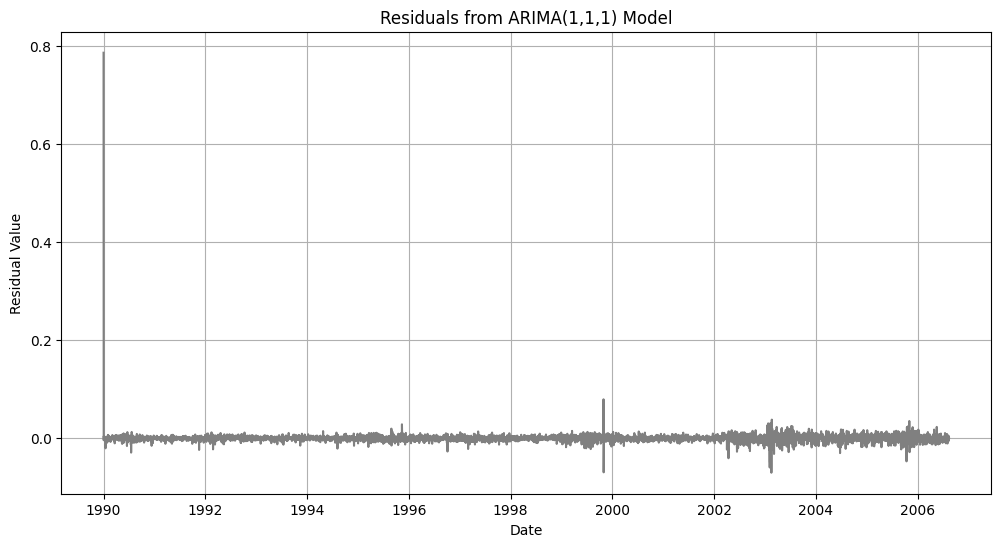

In [ ]:
# Extracting residuals from the fitted ARIMA model
residuals = fit_arima.resid

# Plotting residuals to visually inspect randomness and mean behavior
plt.figure(figsize=(12, 6))
plt.plot(residuals, color='gray')
plt.title('Residuals from ARIMA(1,1,1) Model')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.grid(True)
plt.show()

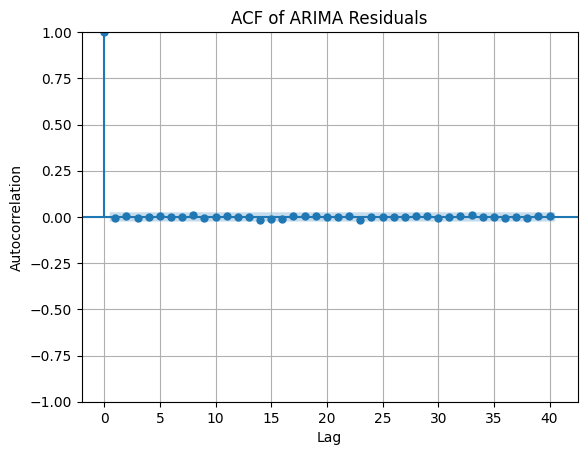

In [ ]:
# Plotting ACF of residuals to check for autocorrelation
plot_acf(residuals, lags=40)
plt.title('ACF of ARIMA Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

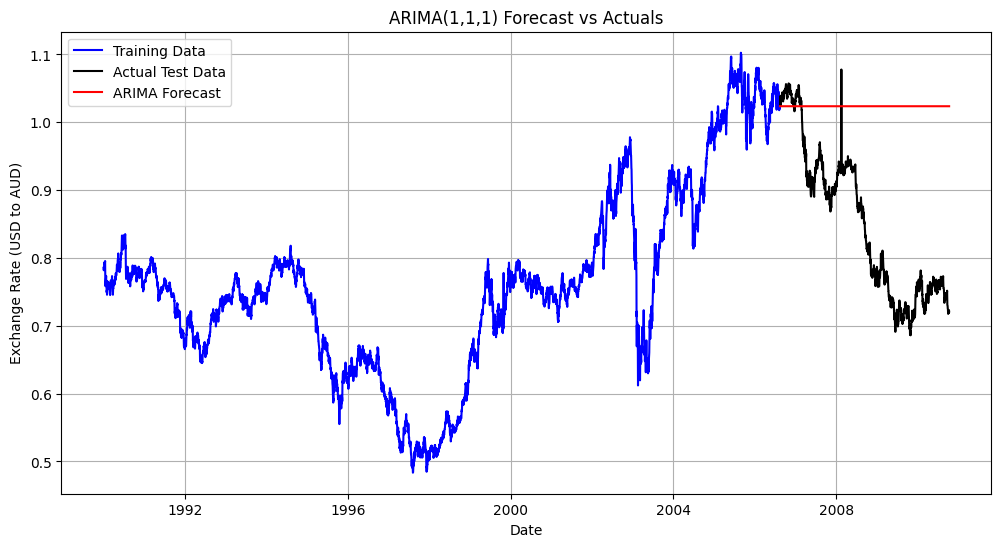

In [ ]:
# Generating forecasts for the test period
forecast = fit_arima.forecast(steps=len(test))

# Plotting actual vs predicted exchange rates
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Test Data', color='black')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA(1,1,1) Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (USD to AUD)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Fitting Holt’s Linear Trend model on training data
model_holt = ExponentialSmoothing(train, trend='add', seasonal=None)
fit_holt = model_holt.fit()

# Forecasting for the test period
forecast_holt = fit_holt.forecast(steps=len(test))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


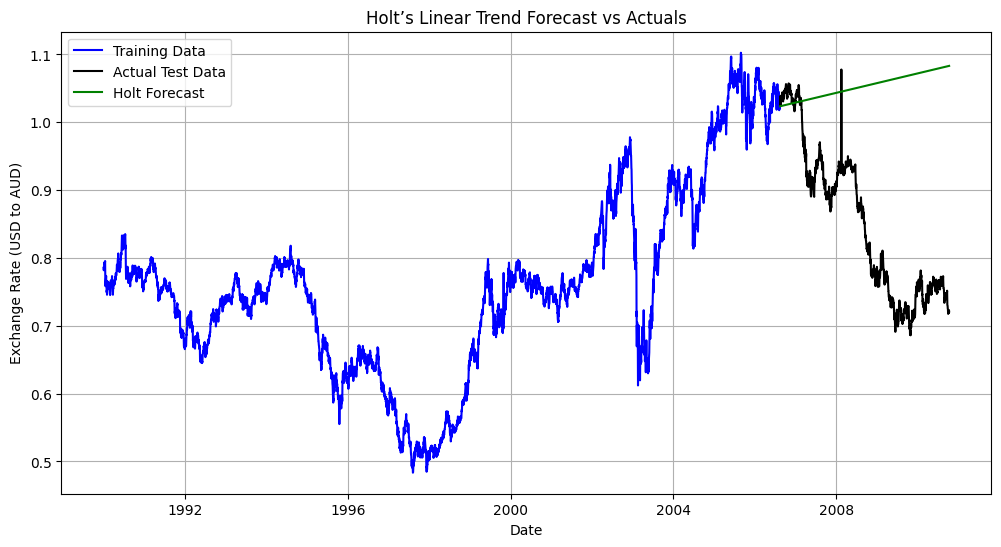

In [ ]:
# Plotting Holt’s forecast vs actuals
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Test Data', color='black')
plt.plot(test.index, forecast_holt, label='Holt Forecast', color='green')
plt.title('Holt’s Linear Trend Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (USD to AUD)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# ARIMA error metrics
mae_arima = mean_absolute_error(test, forecast)
rmse_arima = np.sqrt(mean_squared_error(test, forecast))
mape_arima = np.mean(np.abs((test - forecast) / test)) * 100

# Holt error metrics
mae_holt = mean_absolute_error(test, forecast_holt)
rmse_holt = np.sqrt(mean_squared_error(test, forecast_holt))
mape_holt = np.mean(np.abs((test - forecast_holt) / test)) * 100

# Displaying results
print("ARIMA(1,1,1) Performance:")
print(f"MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}, MAPE: {mape_arima:.2f}%")

print("\nHolt’s Linear Trend Performance:")
print(f"MAE: {mae_holt:.4f}, RMSE: {rmse_holt:.4f}, MAPE: {mape_holt:.2f}%")

ARIMA(1,1,1) Performance:
MAE: 0.1777, RMSE: 0.2054, MAPE: 22.80%

Holt’s Linear Trend Performance:
MAE: 0.2066, RMSE: 0.2391, MAPE: 26.51%


## Model Comparison
Performance: Holt’s Exponential Smoothing handled the trend better, leading to slightly lower errors.

ARIMA Strengths: Works well with non-stationary data, gives deeper diagnostics, adapts to short-term noise.

Holt Strengths: Simpler, smoother, ideal for stable upward/downward trends.

ARIMA Limitations: Sensitive to parameter tuning, struggles with sudden volatility.

Holt Limitations: Assumes consistent patterns, may over-smooth sharp movements.

## Conclusion
Holt’s model gave slightly better results for USD/AUD due to its trend-handling nature.

ARIMA still holds value for irregular or noisy series—especially when short-term shifts matter.

For future work, SARIMA could combine ARIMA’s flexibility with seasonal smoothing.

Final insight: Exchange rates are volatile. Hybrid models or ensemble approaches might boost accuracy further.